## show the training statistics

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import re
import glob
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from m3util.viz.layout import layout_fig
from m3util.viz.style import set_style
from m3util.viz.printing import printer
from dl_utils.utils.utils import find_last_epoch_file, sort_tasks_by_size
from dl_utils.analysis.training_statistics import plot_training_history, sort_history_files_by_size
set_style("printing")
printing = printer(basepath = '../../figures/training_history/', fileformats=['png', 'svg'], dpi=600)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn


In [18]:
df = pd.read_csv('../../results/history/training_full_summary.csv')
df

,Name,State,Group,epoch,records,train_loss,valid_loss,valid_noise_loss,valid_atom_loss,train_accuracy,valid_accuracy,valid_noise_accuracy,valid_atom_accuracy
0,09302024-XCiT-dataset_v5_size-10m,finished,dataset_v5_size_vs_records-XCiT,20,162894513,0.007143,0.013827,0.130110,0.777767,0.997795,0.996754,0.974618,0.918574
1,09302024-XCiT-dataset_v5_size-2m,finished,dataset_v5_size_vs_records-XCiT,50,84069723,0.002518,0.036749,0.244863,1.043416,0.999116,0.995537,0.964333,0.918108
2,09302024-XCiT-dataset_v5_size-5m,finished,dataset_v5_size_vs_records-XCiT,20,81499273,0.005595,0.015812,0.249501,0.946104,0.998069,0.996476,0.960451,0.909779
3,09302024-XCiT-dataset_v5_size-1m,finished,dataset_v5_size_vs_records-XCiT,100,59215473,0.002574,0.045677,0.331412,1.452604,0.999101,0.994453,0.954206,0.886279
4,09302024-XCiT-dataset_v5_size-500k,finished,dataset_v5_size_vs_records-XCiT,150,62657117,0.002475,0.060843,0.361368,1.774735,0.999119,0.993102,0.944157,0.867804
5,09112024-resnet50-dataset_v5_size-10m,finished,dataset_v5_size_vs_records,20,162894513,0.012698,0.018234,0.204704,0.902724,0.996928,0.995358,0.945480,0.858064
6,09032024-resnet50-dataset_v5_size-5m,finished,dataset_v5_size_vs_records,20,81499273,0.011643,0.020937,0.273390,1.183674,0.997277,0.994947,0.935147,0.842422
7,09282024-FPN-dataset_v5_size-10m,finished,dataset_v5_size_vs_records-FPN,20,162894513,0.010372,0.016832,0.261832,1.441882,0.997425,0.995890,0.950745,0.828819
8,09052024-resnet50-dataset_v5_size-2m,finished,dataset_v5_size_vs_records,40,66933453,0.026900,0.059126,0.425913,0.865291,0.993397,0.985476,0.872951,0.828740
9,09272024-FPN-dataset_v5_size-5m,finished,dataset_v5_size_vs_records-FPN,20,81499273,0.006962,0.020497,0.237720,1.737271,0.997817,0.995589,0.953284,0.813172


In [ ]:
dataset_size_dict = {
    '1k': 1000,
    '10k': 10000,
    '100k': 100000,
    '500k': 500000,
    '1m': 1000000,
    '2m': 2000000,
    '5m': 5000000,
    '10m': 10000000,
}
task_names, model_names, dataset_sizes = [], [], []
for name in df['Name']:
    model_name = re.split(r'[-_]', name)[1]
    dataset_size = re.split(r'[-_]', name)[5]
    task_name = model_name + '-' + str(dataset_size)
    
    dataset_size_int = dataset_size_dict[re.split(r'[-_]', name)[5]]
    task_names.append(task_name)
    model_names.append(model_name)
    dataset_sizes.append(dataset_size_int)
    
df_summary = df.copy()
df_summary['Task_name'] = task_names
df_summary['Task_name'] = df_summary['Task_name'].str.replace('resnet50', 'ResNet50')
df_summary['Model_name'] = model_names
df_summary.replace({'Model_name': {'resnet50': 'ResNet50'}}, inplace=True)
df_summary['Dataset_size'] = dataset_sizes
df_summary.drop(columns=['Name', 'State', 'Group', 'records', 'epoch'], inplace=True)
new_order = ['Task_name', 'Model_name','Dataset_size', 'train_loss', 'valid_loss', 'valid_noise_loss', 'valid_atom_loss', 'train_accuracy', 'valid_accuracy', 'valid_noise_accuracy', 'valid_atom_accuracy']
df_summary = df_summary[new_order]
df_summary = df_summary.sort_values(by='Task_name')  # Sort by column 'A'
df_summary.to_csv('../../results/history/training_summary.csv', index=False)
df_summary

,Task_name,Model_name,Dataset_size,train_loss,valid_loss,valid_noise_loss,valid_atom_loss,train_accuracy,valid_accuracy,valid_noise_accuracy,valid_atom_accuracy
16,FPN-100k,FPN,100000,0.001644,0.560978,3.234451,4.122468,0.999463,0.918445,0.434716,0.557819
7,FPN-10m,FPN,10000000,0.010372,0.016832,0.261832,1.441882,0.997425,0.995890,0.950745,0.828819
11,FPN-1m,FPN,1000000,0.002628,0.069037,0.497664,2.273154,0.999097,0.991460,0.922578,0.774495
12,FPN-2m,FPN,2000000,0.008375,0.042212,0.342222,1.915271,0.997823,0.992023,0.928784,0.769868
13,FPN-500k,FPN,500000,0.002160,0.108319,0.766391,3.550172,0.999243,0.985995,0.868971,0.665324
9,FPN-5m,FPN,5000000,0.006962,0.020497,0.237720,1.737271,0.997817,0.995589,0.953284,0.813172
17,ResNet50-100k,ResNet50,100000,0.002237,0.869309,3.853907,4.233155,0.999428,0.875589,0.371804,0.543039
5,ResNet50-10m,ResNet50,10000000,0.012698,0.018234,0.204704,0.902724,0.996928,0.995358,0.945480,0.858064
10,ResNet50-1m,ResNet50,1000000,0.003058,0.083851,0.669094,2.162077,0.999058,0.988178,0.878353,0.780975
8,ResNet50-2m,ResNet50,2000000,0.026900,0.059126,0.425913,0.865291,0.993397,0.985476,0.872951,0.828740


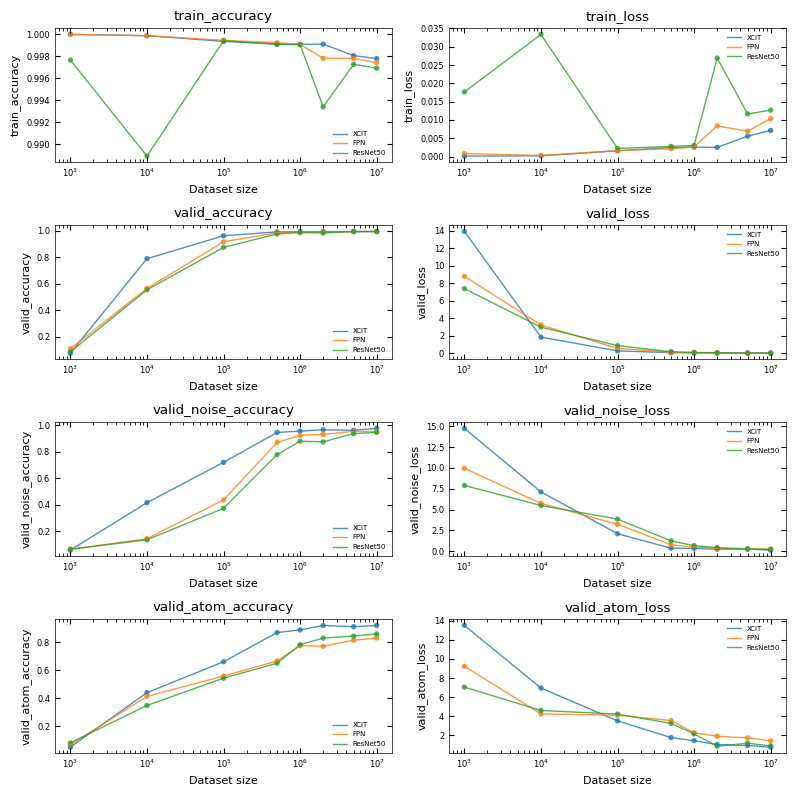

In [ ]:
fig, axes = layout_fig(8, 2, figsize=(8, 8), layout='tight')
keys = ["train_accuracy", "train_loss", "valid_accuracy", "valid_loss", "valid_noise_accuracy", "valid_noise_loss", "valid_atom_accuracy", "valid_atom_loss"]
for ax, key in zip(axes, keys):
    sns.scatterplot(data=df_summary, x='Dataset_size', y=key, hue='Model_name', ax=ax, s=15, edgecolor='none', alpha=0.8, legend=False)
    sns.lineplot(data=df_summary, x='Dataset_size', y=key, hue='Model_name', ax=ax, linewidth=1, alpha=0.8)
    if key[-8:] == 'accuracy':
        ax.set_ylim(0, 1)
    ax.set_xscale('log')
    ax.set_xlabel('Dataset size')
    ax.set_ylabel(key)
    if 'loss' in key:
        ax.legend(loc='upper right')
    else:
        ax.legend(loc='lower right')
plt.savefig('../../figures/training_statistics.png', dpi=600)
plt.savefig('../../figures/training_statistics.svg', dpi=600)
plt.show()